In [3]:
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# --- Tsybakov Noise and Loss Definitions ---
# (Vectorized versions)
eta = lambda x: 1/(1+np.exp(-x))
inverse_eta = lambda x: np.log(x/(1-x))

loss = lambda x: np.log(1 + np.exp(-x))
margin_loss = lambda h_x, y: loss(y * h_x)

# Note: We removed the 'h' parameter from these lambdas to make them purely mathematical
# We will calculate h(x) once and pass the result in.
C_surr_val = lambda h_val, x: eta(x) * margin_loss(h_val, 1) + (1-eta(x)) * margin_loss(h_val, -1)
C_surr_star = lambda x: -1*(eta(x) * np.log(eta(x)) + (1-eta(x))*np.log(1-eta(x))) 
C_target_val = lambda h_val, x: eta(x) * (h_val < 0) + (1-eta(x)) * (h_val > 0) 
C_target_star = lambda x: np.minimum(eta(x), 1-eta(x)) # vectorized min

def get_errors(X, Y):
    classifier = MLPClassifier(
        hidden_layer_sizes=(5,), # Two hidden layers
        activation='relu',
        solver='sgd',
        alpha=0,
        learning_rate='constant',
        learning_rate_init=0.005,
        random_state=42,
        max_iter=1 
    )
    
    # --- FIX 1: Dynamic Forward Pass ---
    # Calculates the raw output logit for ANY number of layers
    def get_logits(X_input):
        if not hasattr(classifier, 'coefs_'):
            return np.zeros(X_input.shape[0])

        # Input layer
        activations = X_input

        # Iterate through all hidden layers (weights + bias)
        # The 'coefs_' list has length = n_layers - 1
        for i in range(len(classifier.coefs_) - 1):
            W = classifier.coefs_[i]
            b = classifier.intercepts_[i]
            
            # Linear step
            z = np.dot(activations, W) + b
            
            # Activation step (ReLU)
            activations = np.maximum(0, z)

        # Output layer (Linear, no ReLU)
        W_last = classifier.coefs_[-1]
        b_last = classifier.intercepts_[-1]
        logits = np.dot(activations, W_last) + b_last
        
        return logits.ravel() # Flatten to 1D array

    all_classes = np.unique(Y)
    delta_C_surr = []
    delta_C_target = []

    # --- FIX 2: Larger Batch Size ---
    chunk_size = 5
    num_chunks = len(X) // chunk_size

    # Limit iterations
    for i in range(min(num_chunks, 1000)):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        X_chunk = X[start_idx:end_idx]
        y_chunk = Y[start_idx:end_idx]

        if i == 0:
            classifier.partial_fit(X_chunk, y_chunk, classes=all_classes)
        else:
            classifier.partial_fit(X_chunk, y_chunk)
        
        # --- FIX 3: Vectorized Error Calculation ---
        # 1. Get logits for the ENTIRE dataset X in one go
        # (This replaces the slow list comprehension loop)
        h_vals = get_logits(X)
        
        # 2. Flatten X for mathematical operations
        x_flat = X.ravel()
        
        # 3. Compute costs using numpy arrays
        # All these functions now operate on arrays, not scalars
        surr_loss = C_surr_val(h_vals, x_flat)
        surr_star = C_surr_star(x_flat)
        
        target_loss = C_target_val(h_vals, x_flat)
        target_star = C_target_star(x_flat)

        temp_surr = surr_loss - surr_star
        temp_target = target_loss - target_star
        
        delta_C_surr.append(temp_surr)
        delta_C_target.append(temp_target)

    return delta_C_surr, delta_C_target

# ... (Plotting functions remain the same) ...
# ... (Main execution block remains the same) ...

def plot_sample_errors(delta_C_surr, delta_C_target, ax, alpha):
    cmap = plt.cm.viridis 
    num_colors = len(delta_C_surr)

    for i in range(num_colors):
        # Adding epsilon to avoid log(0)
        arr_surr = [np.log(x + 1e-15) for x in delta_C_surr[i]]
        arr_target = [np.log(x + 1e-15) for x in delta_C_target[i]]

        color = cmap(alpha) 

        # Downsample for cleaner plotting
        if len(arr_surr) > 0:
            idx = np.random.choice(len(arr_surr), size=min(100, len(arr_surr)), replace=False)
            arr_surr_sampled = [arr_surr[j] for j in idx]
            arr_target_sampled = [arr_target[j] for j in idx]

            ax.scatter(arr_surr_sampled, [0.5 * a for a in arr_surr_sampled], color='red', s=5)
            ax.scatter(arr_surr_sampled, arr_target_sampled, alpha=0.2, color=color, label=str(i), s=10)

def plot_mean_errors(delta_C_surr, delta_C_target, ax, alpha):
    cmap = plt.cm.viridis
    num_colors = len(delta_C_surr)

    for i in range(num_colors):
        mean_surr = sum(delta_C_surr[i])/(len(delta_C_surr[i]))
        mean_target = sum(delta_C_target[i])/(len(delta_C_target[i]))

        color = cmap(alpha) 

        ax.scatter(np.log(mean_surr + 1e-15), 1/(2-alpha)*np.log(mean_surr + 1e-15), color='red') 
        ax.scatter(np.log(mean_surr + 1e-15), np.log(mean_target + 1e-15), alpha=0.6, color=color)

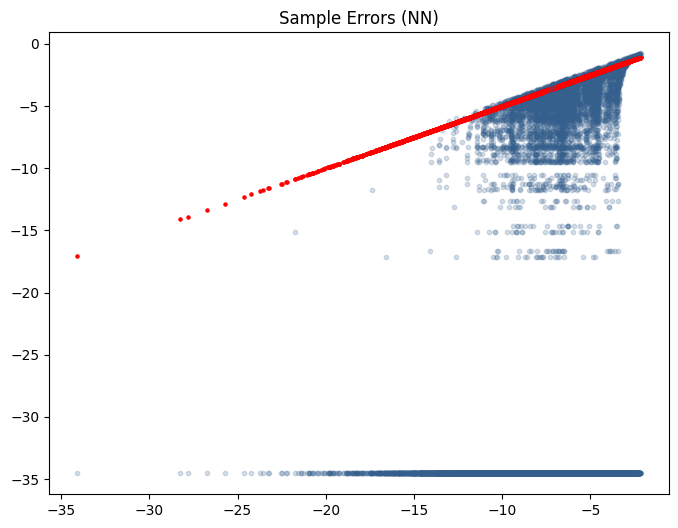

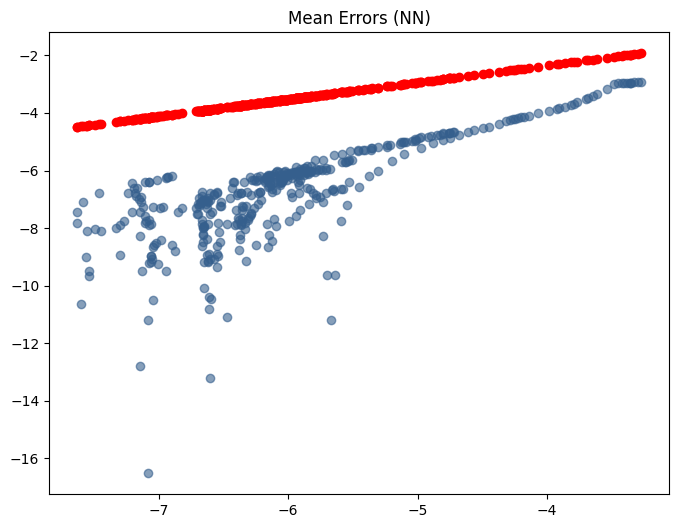

In [4]:
# --- Main Execution ---

fig1, sample_ax = plt.subplots(1, 1, figsize=(8, 6))
fig2, mean_ax  = plt.subplots(1, 1, figsize=(8, 6))
sample_ax.set_title("Sample Errors (NN)")
mean_ax.set_title("Mean Errors (NN)")

# Using alpha = 0.3
for alpha in [0.3]:
    beta = alpha/(1-alpha)

    # Generate Data
    signal = [((x) ** (1/beta))/2 for x in np.random.rand(1000)] + [0.01, 0.49]
    arr = []

    for t in signal:
        arr.extend([0.5 + t, 0.5 - t])

    X = [inverse_eta(x) for x in arr]
    Y = [np.random.binomial(n=1, p=eta(x))*2 - 1 for x in X]

    # Shuffle
    random_indices = np.random.permutation(range(len(X)))
    X = np.array(X)
    Y = np.array(Y)

    X = X[random_indices]
    Y = Y[random_indices]

    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Train and Evaluate
    delta_C_surr, delta_C_target = get_errors(X, Y)

    plot_sample_errors(delta_C_surr, delta_C_target, sample_ax, alpha)
    plot_mean_errors(delta_C_surr, delta_C_target, mean_ax, alpha)

plt.show()